In [1]:
import pandas as pd
import numpy as np
import csv
pd.set_option('display.max_columns', 100)
from IPython.display import display

In [2]:
# Read data from CSV
squawka = []
with open('epl-season16-17-week1-33.csv', 'r', errors='ignore') as squawka_csv:
    squawka_reader = csv.reader(squawka_csv)
    for row in squawka_reader:
        squawka.append(row)

# Convert percentage features to decimal
squawka = pd.DataFrame(squawka[1:], columns=squawka[0])
passing = squawka.passing.values
passing = [int(x.replace('%', ''))/100 for x in passing]
tackles = squawka.tackles.values
tackles = [int(x.replace('%', ''))/100 for x in tackles]
aerial_duels = squawka.aerial_duels.values
aerial_duels = [int(x.replace('%', ''))/100 for x in aerial_duels]

squawka = squawka.drop(['passing', 'tackles', 'aerial_duels'], axis=1)
squawka['passing'] = pd.Series(passing, index=squawka.index)
squawka['tackles'] = pd.Series(tackles, index=squawka.index)
squawka['aerial_duels'] = pd.Series(aerial_duels, index=squawka.index)

In [3]:
# Show first 5 rows
squawka.head()

,name,team,match_id,shots,chances,crossing,set_piece,take_ons,interceptions,clearance,fouls,cards,throw_ins,blocks,gk,goal,own_goal,date,stadium,league,did_play,did_start,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,score,passing,tackles,aerial_duels
0,Aaron Cresswell,WESTHAM,WESTHAMvMANCITY,1,0,2,0,0,3,2,0,0,3,2,0,0,0,01.02.2017,London Stadium,English Premier League,1,1,0,4,7,7,-23,-30,-32,-34,-40,-40,-42,-41,-37,-37,-44,-44,-53,-51,-50,0v4,0.57,0.50,0.43
1,Aaron Cresswell,WESTHAM,B'MOUTHvWESTHAM,0,1,6,0,0,0,2,0,0,8,1,0,0,0,11.03.2017,Vitality Stadium,English Premier League,1,1,0,-9,-12,-14,-16,-16,-28,-36,-32,-31,-38,-38,-37,-31,-31,-31,-30,-32,-38,3v2,0.70,0.50,1.00
2,Aaron Cresswell,WESTHAM,C.PALACEvWESTHAM,1,2,3,0,0,1,2,1,2,4,1,0,0,0,15.10.2016,Selhurst Park,English Premier League,1,1,0,-5,-1,-3,14,13,13,11,12,13,9,9,11,11,11,-35,-35,-35,-35,0v1,0.60,0.00,0.00
3,Aaron Cresswell,WESTHAM,S'HAMPTONvWESTHAM,1,0,5,0,2,2,3,0,1,3,6,0,0,0,04.02.2017,St. Mary's Stadium,English Premier League,1,1,0,12,10,-1,3,2,11,11,13,13,12,14,17,17,10,6,-8,-17,-30,1v3,0.79,0.50,0.50
4,Aaron Cresswell,WESTHAM,WESTHAMvLEICESTER,0,1,6,0,0,0,2,1,0,6,1,0,0,0,18.03.2017,London Stadium,English Premier League,1,1,0,-9,-18,-19,-18,-20,-19,-12,-18,-20,-16,-17,-16,-17,-10,-9,-9,-9,-14,2v3,0.71,0.33,0.67


In [4]:
# 11621 rows/players (with repeats), 45 features
squawka.values.shape

(11621, 45)

In [5]:
# Do not consider a player for analysis if he has not played >= 10 games so far

# Find the list of players who should be excluded

did_play_vec = [int(b) for b in squawka['did_play'].values]

squawka_exclude = pd.DataFrame(did_play_vec,
                               index=squawka['name'].values, columns=['did_play'])

squawka_exclude = squawka_exclude.groupby(squawka_exclude.index).sum()

squawka_exclude = squawka_exclude[squawka_exclude['did_play'] < 10]

exclude_list = squawka_exclude.index.values

In [6]:
from sklearn.preprocessing import Imputer, StandardScaler
from scipy.stats import normaltest
import matplotlib.pyplot as plt

In [7]:
# Replace '?' with 'NaN' for Imputer
squawka = squawka.replace('?', 'NaN')

# Split dataset into following categories
squawka_count = squawka[['shots', 'chances', 'crossing',
                         'set_piece', 'take_ons', 'interceptions',
                         'clearance', 'fouls', 'cards',
                         'throw_ins', 'blocks', 'gk', 'goal',
                         'own_goal']]

squawka_bin = squawka[['did_play', 'did_start']]

squawka_ts = squawka[['0', '5', '10', '15', '20', '25', '30',
                      '35', '40', '45', '50', '55', '60', '65',
                      '70', '75', '80', '85', '90']]

squawka_percent = squawka[['passing', 'tackles', 'aerial_duels']]

squawka_rest = squawka[['name', 'team', 'match_id', 'date', 'stadium',
                        'league', 'score']]

In [8]:
# Imputation
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

count_data = imputer.fit_transform(squawka_count.values)
ts_data = imputer.fit_transform(squawka_ts.values)
percent_data = imputer.fit_transform(squawka_percent.values)

squawka_count = pd.DataFrame(count_data, columns=
                            ['shots', 'chances', 'crossing',
                             'set_piece', 'take_ons', 'interceptions',
                             'clearance', 'fouls', 'cards',
                             'throw_ins', 'blocks', 'gk', 'goal',
                             'own_goal'])
squawka_ts = pd.DataFrame(ts_data, columns=
                          ['0', '5', '10', '15', '20', '25', '30',
                          '35', '40', '45', '50', '55', '60', '65',
                          '70', '75', '80', '85', '90'])
squawka_percent = pd.DataFrame(percent_data, columns=
                               ['passing', 'tackles', 'aerial_duels'])

In [9]:
# Create First half, Second half and Full time average ratings
squawka_first_half = squawka_ts[['0', '5', '10', '15', '20', '25',
                                 '30', '35', '40', '45']]
squawka_first_half_avg = pd.DataFrame(squawka_first_half.mean(axis=1),
                                     columns=['first_half_avg'])

squawka_second_half = squawka_ts[['50', '55', '60', '65',
                                  '70', '75', '80', '85', '90']]
squawka_second_half_avg = pd.DataFrame(squawka_second_half.mean(axis=1),
                                     columns=['second_half_avg'])

squawka_full = squawka_ts[['0', '5', '10', '15', '20', '25',
                           '30', '35', '40', '45', '50', '55',
                           '60', '65', '70', '75', '80', '85', '90']]
squawka_full_avg = pd.DataFrame(squawka_full.mean(axis=1),
                                     columns=['full_avg'])

display(squawka_first_half_avg.head())
display(squawka_second_half_avg.head())
display(squawka_full_avg.head())

,first_half_avg
0,-18.1
1,-19.4
2,6.7
3,7.4
4,-15.3


,second_half_avg
0,-44.333333
1,-34.000000
2,-9.888889
3,2.333333
4,-13.000000


,full_avg
0,-30.526316
1,-26.315789
2,-1.157895
3,5.000000
4,-14.210526


In [10]:
# Create new Dataframe for new features
new_squawka = pd.DataFrame(squawka_count.values,
                           index=squawka_rest['name'].values,
                           columns=
                           ['shots', 'chances', 'crossing',
                            'set_piece', 'take_ons', 'interceptions',
                            'clearance', 'fouls', 'cards',
                            'throw_ins', 'blocks', 'gk', 'goal',
                            'own_goal'])
new_squawka['full_avg'] = squawka_full_avg.values
#new_squawka['first_half_avg'] = squawka_first_half_avg.values
#new_squawka['second_half_avg'] = squawka_second_half_avg.values
new_squawka['passing'] = squawka_percent['passing'].values
new_squawka['tackles'] = squawka_percent['tackles'].values
new_squawka['aerial_duels'] = squawka_percent['aerial_duels'].values
new_squawka['games_played'] = np.ones(squawka.values.shape[0])

In [11]:
new_squawka.head()

,shots,chances,crossing,set_piece,take_ons,interceptions,clearance,fouls,cards,throw_ins,blocks,gk,goal,own_goal,full_avg,passing,tackles,aerial_duels,games_played
Aaron Cresswell,1.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,-30.526316,0.57,0.50,0.43,1.0
Aaron Cresswell,0.0,1.0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,-26.315789,0.70,0.50,1.00,1.0
Aaron Cresswell,1.0,2.0,3.0,0.0,0.0,1.0,2.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0,-1.157895,0.60,0.00,0.00,1.0
Aaron Cresswell,1.0,0.0,5.0,0.0,2.0,2.0,3.0,0.0,1.0,3.0,6.0,0.0,0.0,0.0,5.000000,0.79,0.50,0.50,1.0
Aaron Cresswell,0.0,1.0,6.0,0.0,0.0,0.0,2.0,1.0,0.0,6.0,1.0,0.0,0.0,0.0,-14.210526,0.71,0.33,0.67,1.0


In [12]:
# Merge stats for same player
squawka_sum = new_squawka.groupby(new_squawka.index).sum()
display(squawka_sum.head())

# Calculate average performance for each player
squawka_avg = squawka_sum.divide(squawka_sum['games_played'],
                                 axis='index').drop('games_played', axis=1)
display(squawka_avg.head())

,shots,chances,crossing,set_piece,take_ons,interceptions,clearance,fouls,cards,throw_ins,blocks,gk,goal,own_goal,full_avg,passing,tackles,aerial_duels,games_played
Aaron Cresswell,10.0,14.0,77.0,0.0,16.0,23.0,71.0,9.0,4.0,142.0,46.0,0.0,0.0,0.0,-41.842105,15.66,7.74,10.88,22.0
Aaron Lennon,5.0,6.0,11.0,0.0,5.0,4.0,13.0,1.0,0.0,1.0,12.0,0.0,0.0,0.0,26.789474,9.12,7.17,0.00,22.0
Aaron Ramsey,29.0,13.0,15.0,0.0,17.0,10.0,10.0,11.0,3.0,7.0,12.0,0.0,0.0,0.0,71.947368,14.37,2.98,2.67,17.0
Aaron Wan-Bissaka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,2.0
Abdoulaye Doucour,19.0,5.0,4.0,0.0,6.0,13.0,14.0,6.0,3.0,0.0,10.0,0.0,1.0,0.0,42.526316,11.50,3.66,4.92,18.0


,shots,chances,crossing,set_piece,take_ons,interceptions,clearance,fouls,cards,throw_ins,blocks,gk,goal,own_goal,full_avg,passing,tackles,aerial_duels
Aaron Cresswell,0.454545,0.636364,3.500000,0.0,0.727273,1.045455,3.227273,0.409091,0.181818,6.454545,2.090909,0.0,0.000000,0.0,-1.901914,0.711818,0.351818,0.494545
Aaron Lennon,0.227273,0.272727,0.500000,0.0,0.227273,0.181818,0.590909,0.045455,0.000000,0.045455,0.545455,0.0,0.000000,0.0,1.217703,0.414545,0.325909,0.000000
Aaron Ramsey,1.705882,0.764706,0.882353,0.0,1.000000,0.588235,0.588235,0.647059,0.176471,0.411765,0.705882,0.0,0.000000,0.0,4.232198,0.845294,0.175294,0.157059
Aaron Wan-Bissaka,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Abdoulaye Doucour,1.055556,0.277778,0.222222,0.0,0.333333,0.722222,0.777778,0.333333,0.166667,0.000000,0.555556,0.0,0.055556,0.0,2.362573,0.638889,0.203333,0.273333


In [13]:
# Remove players from exclude list
squawka_avg = squawka_avg.drop(exclude_list, axis=0)
squawka_avg

,shots,chances,crossing,set_piece,take_ons,interceptions,clearance,fouls,cards,throw_ins,blocks,gk,goal,own_goal,full_avg,passing,tackles,aerial_duels
Aaron Cresswell,0.454545,0.636364,3.500000,0.000000,0.727273,1.045455,3.227273,0.409091,0.181818,6.454545,2.090909,0.000000,0.000000,0.000000,-1.901914,0.711818,0.351818,0.494545
Aaron Lennon,0.227273,0.272727,0.500000,0.000000,0.227273,0.181818,0.590909,0.045455,0.000000,0.045455,0.545455,0.000000,0.000000,0.000000,1.217703,0.414545,0.325909,0.000000
Aaron Ramsey,1.705882,0.764706,0.882353,0.000000,1.000000,0.588235,0.588235,0.647059,0.176471,0.411765,0.705882,0.000000,0.000000,0.000000,4.232198,0.845294,0.175294,0.157059
Abdoulaye Doucour,1.055556,0.277778,0.222222,0.000000,0.333333,0.722222,0.777778,0.333333,0.166667,0.000000,0.555556,0.000000,0.055556,0.000000,2.362573,0.638889,0.203333,0.273333
Abel Hernndez,1.478261,0.434783,0.043478,0.000000,0.304348,0.130435,0.130435,0.739130,0.000000,0.000000,0.391304,0.000000,0.173913,0.000000,-0.247140,0.620870,0.086957,0.276957
Adam Clayton,0.312500,0.531250,0.625000,0.000000,0.625000,1.406250,1.468750,1.218750,0.250000,0.093750,1.687500,0.000000,0.000000,0.000000,4.401316,0.758750,0.321875,0.197813
Adam Forshaw,0.718750,0.656250,1.343750,0.000000,0.812500,1.000000,0.593750,0.781250,0.093750,0.187500,1.062500,0.000000,0.000000,0.000000,3.661184,0.760000,0.279062,0.253750
Adam Lallana,1.592593,1.185185,1.444444,0.000000,1.666667,0.666667,0.888889,0.629630,0.111111,0.333333,1.222222,0.000000,0.259259,0.000000,10.109162,0.844074,0.426667,0.212963
Adam Smith,0.774194,0.677419,1.580645,0.000000,1.935484,1.516129,2.645161,1.322581,0.193548,6.741935,1.806452,0.000000,0.032258,0.032258,-0.215620,0.831290,0.366774,0.333226
Adama Diomande,0.758621,0.413793,0.137931,0.034483,1.034483,0.241379,0.310345,0.655172,0.034483,0.000000,0.827586,0.000000,0.068966,0.000000,-1.847550,0.586207,0.245862,0.289310


In [14]:
# Perform normaltest
print(normaltest(squawka_avg.shots.values))
print(normaltest(squawka_avg.chances.values))
print(normaltest(squawka_avg.crossing.values))
print(normaltest(squawka_avg.set_piece.values))
print(normaltest(squawka_avg.take_ons.values))
print(normaltest(squawka_avg.interceptions.values))
print(normaltest(squawka_avg.clearance.values))
print(normaltest(squawka_avg.fouls.values))
print(normaltest(squawka_avg.cards.values))
print(normaltest(squawka_avg.throw_ins.values))
print(normaltest(squawka_avg['blocks'].values))
print(normaltest(squawka_avg.gk.values))
print(normaltest(squawka_avg.goal.values))
print(normaltest(squawka_avg.own_goal.values))
print()
print(normaltest(squawka_avg.full_avg.values))
#print(normaltest(squawka_avg.first_half_avg.values))
#print(normaltest(squawka_avg.second_half_avg.values))
print()
print(normaltest(squawka_avg.passing.values))
print(normaltest(squawka_avg.tackles.values))
print(normaltest(squawka_avg.aerial_duels.values))

NormaltestResult(statistic=126.17853782411204, pvalue=3.9872975345096281e-28)
NormaltestResult(statistic=141.53795950119149, pvalue=1.8425640964172132e-31)
NormaltestResult(statistic=135.5240925436899, pvalue=3.7266381164755206e-30)
NormaltestResult(statistic=169.33927641052813, pvalue=1.6921674728566809e-37)
NormaltestResult(statistic=166.19361941637524, pvalue=8.1566923096813613e-37)
NormaltestResult(statistic=27.748919226208521, pvalue=9.4275479644484977e-07)
NormaltestResult(statistic=90.370599046806575, pvalue=2.3783389800193232e-20)
NormaltestResult(statistic=19.306938166694025, pvalue=6.4202456590749523e-05)
NormaltestResult(statistic=28.275501408079222, pvalue=7.2452417779874131e-07)
NormaltestResult(statistic=170.24618798121253, pvalue=1.0752513521188178e-37)
NormaltestResult(statistic=17.832226541156388, pvalue=0.00013420886592711961)
NormaltestResult(statistic=365.69605124005329, pvalue=3.8914499248102905e-80)
NormaltestResult(statistic=211.42739135828813, pvalue=1.227793429

In [15]:
# The distribution of the features is not very Gaussian, so it may not
# be suitable for z-score standardization. Min-max scaling is perhaps a better choice.
# Due to time constraints, we will stick to K-means clustering for this project.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

squawka_avg_scaled = squawka_avg
squawka_avg_scaled[:] = scaler.fit_transform(squawka_avg_scaled.values)

In [16]:
squawka_avg_scaled.head()

,shots,chances,crossing,set_piece,take_ons,interceptions,clearance,fouls,cards,throw_ins,blocks,gk,goal,own_goal,full_avg,passing,tackles,aerial_duels
Aaron Cresswell,0.103668,0.173554,0.401274,0.0,0.101399,0.298701,0.331776,0.180481,0.409091,0.683422,0.821429,0.0,0.000000,0.0,0.087009,0.718029,0.564037,0.654408
Aaron Lennon,0.051834,0.074380,0.057325,0.0,0.031687,0.051948,0.060748,0.020053,0.000000,0.004813,0.214286,0.0,0.000000,0.0,0.180161,0.303440,0.522500,0.000000
Aaron Ramsey,0.389061,0.208556,0.101161,0.0,0.139423,0.168067,0.060473,0.285467,0.397059,0.043599,0.277311,0.0,0.000000,0.0,0.270174,0.904180,0.281033,0.207828
Abdoulaye Doucour,0.240741,0.075758,0.025478,0.0,0.046474,0.206349,0.079958,0.147059,0.375000,0.000000,0.218254,0.0,0.066667,0.0,0.214347,0.616319,0.325985,0.361689
Abel Hernndez,0.337147,0.118577,0.004985,0.0,0.042433,0.037267,0.013409,0.326087,0.000000,0.000000,0.153727,0.0,0.208696,0.0,0.136420,0.591188,0.139409,0.366483


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


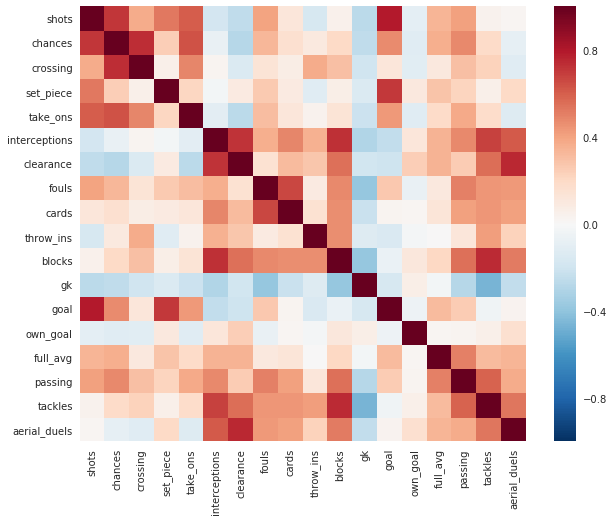

In [17]:
# Compute pairwise correlation of columns

import seaborn as sns
%matplotlib inline

plt.subplots(figsize=(10, 8))
corrmat = squawka_avg_scaled.corr()
sns.heatmap(corrmat)

In [18]:
# Many of the variables are correlated. It may be useful to perform PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=10)

# Drop feature 'full_avg'
# The reason for this is that I want to avoid ending up with
# clusters that are defined by the performance score. I want
# to first find clusters based on position/playing style
# Also omit 'own_goal' because it doesn't really help

pca.fit(squawka_avg_scaled.drop(['full_avg', 'own_goal'], axis=1).values)
print(pca.explained_variance_ratio_)
print()
print('The first 10 principal components explain:')
print(sum(pca.explained_variance_ratio_), 'of total variance')

[ 0.37710905  0.19422684  0.11408689  0.06793862  0.05315841  0.03249451
  0.0287464   0.02755406  0.02288727  0.01969214]

The first 10 principal components explain:
0.93789419919 of total variance


In [19]:
# Peform PCA

squawka_avg_scaled_pca = pca.fit_transform(squawka_avg_scaled.drop(['full_avg',
                                                                    'own_goal'], axis=1).values)

squawka_avg_scaled_pca.shape

(370, 10)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


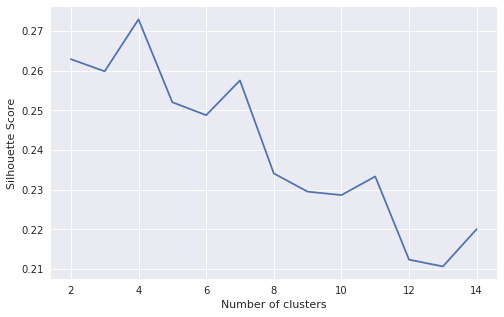

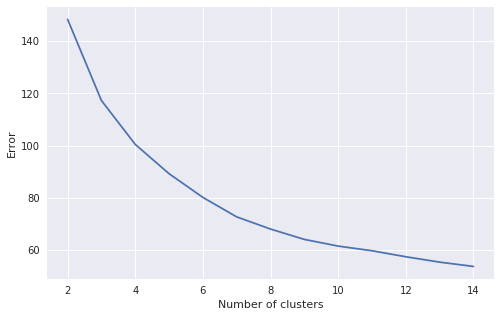

In [20]:
# Cluster on PCA-transformed data

# K-means++

from sklearn.cluster import KMeans
from sklearn import metrics

# K-means++

# Determine number of clusters using Silhouette Score
def kmeans_silhouette_eval(X, max_clusters):
    s = np.zeros(max_clusters + 1)
    s[0] = 0
    s[1] = 0
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(init='k-means++', n_clusters=k)
        labels = kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X, labels, metric='euclidean')
    plt.plot(range(2, len(s)), s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
# Determine number of clusters using error function
def kmeans_error_eval(X, max_clusters):
    error = np.zeros(max_clusters + 1)
    error[0] = 0
    error[1] = 0
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(init='k-means++', n_clusters=k)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(2, len(error)), error[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

X_scaled_pca = squawka_avg_scaled_pca

plt.figure(figsize=(8, 5))
kmeans_silhouette_eval(X_scaled_pca, 14)
plt.figure(figsize=(8, 5))
kmeans_error_eval(X_scaled_pca, 14)

In [22]:
# Use 7 clusters based on the results above
# The point of clustering here is to hopefully find players
# who play in the similar position/have similar playing styles

from collections import defaultdict

kmeans_pca = KMeans(init='k-means++', n_clusters=7).fit(X_scaled_pca)

# See they players in each cluster

cluster_dict_pca = defaultdict(list)
for cluster_label, ind in zip(kmeans_pca.labels_, range(len(kmeans_pca.labels_))):
    cluster_dict_pca[cluster_label].append(squawka_avg_scaled.axes[0][ind])

cluster_dict_pca

defaultdict(list,
            {0: ['Adam Clayton',
              'Adam Forshaw',
              "Alfred N'Diaye",
              'Ander Herrera',
              'Andrew Surman',
              'Claudio Yacob',
              'Dan Gosling',
              'Daniel Drinkwater',
              'Dean Marney',
              'Didier Ndong',
              'Emre Can',
              'Etienne Capoue',
              'Fabio Borini',
              'Fernandinho',
              'Francis Coquelin',
              'Gareth Barry',
              'Gast_n Ram_rez',
              'George Boyd',
              'Glenn Whelan',
              'Granit Xhaka',
              'Harry Arter',
              'Idrissa Gueye',
              'Jack Cork',
              'Jack Rodwell',
              'Jake Livermore',
              'James McArthur',
              'James McCarthy',
              'James McClean',
              'Jason Puncheon',
              'Jeff Hendrick',
              'Joe Allen',
              'Joey Barton',
      

### Cluster 0: Good passers of the ball, also good tacklers (CM, CDM)

### Cluster 1: Goalkeepers (GK)

### Cluster 2: Attacking players who like to take opposing players on (RW/RM/LW/LM)

### Cluster 3: Attacking players (CF, CAM)

### Cluster 4: Strikers, goal-scorers, very attack-minded players (ST)

### Cluster 5: Side defenders (LB/RB)

### Cluster 6: Central defenders (CB)

In [49]:
# Compute factor loadings
factor_loadings = pd.DataFrame(pca.components_,
             columns=squawka_avg_scaled.drop(['full_avg','own_goal'], axis=1).columns,
             index = ['PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5',
                     'PC-6', 'PC-7', 'PC-8', 'PC-9', 'PC-10'])
factor_loadings

,shots,chances,crossing,set_piece,take_ons,interceptions,clearance,fouls,cards,throw_ins,blocks,gk,goal,passing,tackles,aerial_duels
PC-1,-0.053626,-0.073432,-0.098319,-0.062381,-0.059946,-0.355972,-0.290844,-0.274629,-0.294315,-0.228772,-0.420595,0.135707,-0.012748,-0.304724,-0.371555,-0.350010
PC-2,0.446914,0.348450,0.277723,0.232519,0.356518,-0.213200,-0.315267,0.223503,0.056481,-0.129512,-0.031933,-0.088816,0.328438,0.241424,-0.024662,-0.173531
PC-3,-0.118528,0.158030,0.447576,-0.266567,0.125722,-0.015394,-0.158929,-0.217818,-0.183497,0.621825,0.170353,-0.001049,-0.183019,-0.045176,0.108661,-0.322719
PC-4,0.171018,0.005529,0.041088,0.431262,-0.024779,-0.057848,0.303920,-0.343966,-0.567941,0.225872,-0.011873,-0.025012,0.313431,-0.047942,0.023109,0.304950
PC-5,0.032718,-0.066377,-0.049341,0.192760,-0.081633,-0.201705,-0.072638,0.318250,0.382576,0.550529,-0.142972,0.065757,0.169514,-0.455181,-0.241510,0.180446
PC-6,-0.004842,0.115635,0.142964,-0.020023,-0.035209,0.044623,0.089392,-0.212757,0.212481,0.100845,-0.209585,0.701507,-0.020292,0.458504,-0.279523,0.170740
PC-7,0.114808,0.194623,0.289831,-0.482703,0.133124,-0.184223,0.084509,0.112371,-0.134251,-0.127553,-0.270369,-0.161635,-0.200728,-0.146759,-0.052798,0.601973
PC-8,0.006615,0.155518,0.534827,0.247753,-0.126602,0.139156,0.286257,-0.199271,0.272975,-0.339177,0.214901,-0.000952,-0.093331,-0.412393,-0.212517,-0.107810
PC-9,0.046902,0.023834,0.053822,-0.043997,-0.378585,0.015240,-0.243188,0.383947,-0.391372,-0.043780,0.519233,0.153540,-0.055999,0.065807,-0.417235,0.111662
PC-10,-0.011653,-0.142202,-0.163440,-0.055662,0.681991,-0.097032,0.091636,0.050340,-0.086636,-0.107199,0.373838,0.455390,-0.018490,-0.306392,0.038810,0.050165


In [65]:
cluster_top_components = []
for cluster_num in range(7):
    cluster_top_components.append(np.argsort(kmeans_pca.cluster_centers_[cluster_num])[::-1][0])
cluster_top_components

[8, 0, 1, 0, 1, 2, 3]

In [84]:
cluster_top_features = []
for ind in cluster_top_components:
    cluster_top_features.append(list(factor_loadings.iloc[ind].nlargest(n=4).index))
cluster_top_features

[['blocks', 'fouls', 'gk', 'aerial_duels'],
 ['gk', 'goal', 'shots', 'take_ons'],
 ['shots', 'take_ons', 'chances', 'goal'],
 ['gk', 'goal', 'shots', 'take_ons'],
 ['shots', 'take_ons', 'chances', 'goal'],
 ['throw_ins', 'crossing', 'blocks', 'chances'],
 ['set_piece', 'goal', 'aerial_duels', 'clearance']]

In [139]:
# Identify top players for each cluster
top_players = []

# Cluster 0
cluster0 = squawka_avg_scaled.loc[cluster_dict_pca[0]][cluster_top_features[0]]
cluster0['tot'] = np.sqrt(np.square(cluster0).sum(axis=1))
display(cluster0[cluster0.tot > cluster0.tot.quantile(.75)])

top_players = (top_players +
               list(cluster0[cluster0.tot > cluster0.tot.quantile(.75)].index))

,blocks,fouls,gk,aerial_duels,tot
Alfred N'Diaye,0.471429,0.882353,0.0,0.295085,1.043009
Daniel Drinkwater,0.755495,0.661765,0.0,0.468227,1.108125
Dean Marney,0.710884,0.714286,0.0,0.335854,1.062242
Emre Can,0.533163,0.945378,0.0,0.553875,1.218516
Fernandinho,0.468407,0.695701,0.0,0.690635,1.086454
Gareth Barry,0.582949,0.654649,0.0,0.548082,1.033823
Idrissa Gueye,0.799261,0.623732,0.0,0.558503,1.157491
Joey Barton,0.695055,0.542986,0.0,0.707431,1.130661
Marten de Roon,0.623153,0.836714,0.0,0.651587,1.230031
N'Golo Kant,0.811060,0.725806,0.0,0.326544,1.136329


In [124]:
# Bottom players
#cluster0[cluster0.tot < cluster0.tot.quantile(.25)]

In [141]:
# Cluster 1
cluster1 = squawka_avg_scaled.loc[cluster_dict_pca[1]][cluster_top_features[1]]
cluster1['tot'] = np.sqrt(np.square(cluster1).sum(axis=1))
display(cluster1[cluster1.tot > cluster1.tot.quantile(.75)])

top_players = (top_players +
               list(cluster1[cluster1.tot > cluster1.tot.quantile(.75)].index))

,gk,goal,shots,take_ons,tot
Artur Boruc,0.743201,0.0,0.0,0.004498,0.743214
Heurelho Gomes,0.714869,0.0,0.0,0.004357,0.714883
Jordan Pickford,1.000000,0.0,0.0,0.000000,1.000000
Kasper Schmeichel,0.714869,0.0,0.0,0.005809,0.714893
Lee Grant,0.702614,0.0,0.0,0.000000,0.702614
Lukasz Fabianski,0.653595,0.0,0.0,0.000000,0.653595
Tom Heaton,0.985839,0.0,0.0,0.000000,0.985839
V_ctor Valds,0.665266,0.0,0.0,0.000000,0.665266


In [125]:
# Bottom players
#cluster1[cluster1.tot < cluster1.tot.quantile(.25)]

In [142]:
# Cluster 2
cluster2 = squawka_avg_scaled.loc[cluster_dict_pca[2]][cluster_top_features[2]]
cluster2['tot'] = np.sqrt(np.square(cluster2).sum(axis=1))
display(cluster2[cluster2.tot > cluster2.tot.quantile(.75)])

top_players = (top_players +
               list(cluster2[cluster2.tot > cluster2.tot.quantile(.75)].index))

,shots,take_ons,chances,goal,tot
Christian Eriksen,0.848136,0.230919,0.707386,0.262500,1.158430
Dimitri Payet,0.696881,0.642895,1.000000,0.133333,1.384462
Eden Hazard,0.486550,0.762179,0.590909,0.560000,1.216726
Gylfi Sigurdsson,0.718767,0.249272,0.454545,0.290909,0.932739
Kevin De Bruyne,0.522354,0.251861,0.686217,0.154839,0.911678
M'Baye Niang,0.547368,0.822596,0.218182,0.240000,1.039942
Michail Antonio,0.605566,0.605769,0.282132,0.372414,0.975683
Philippe Coutinho,0.745614,0.482618,0.587413,0.415385,1.143004
Riyad Mahrez,0.456140,0.664583,0.318182,0.200000,0.889368
Ross Barkley,0.539075,0.380245,0.578512,0.145455,0.889394


In [126]:
# Bottom players
#cluster2[cluster2.tot < cluster2.tot.quantile(.25)]

In [143]:
# Cluster 3
cluster3 = squawka_avg_scaled.loc[cluster_dict_pca[3]][cluster_top_features[3]]
cluster3['tot'] = np.sqrt(np.square(cluster3).sum(axis=1))
display(cluster3[cluster3.tot > cluster3.tot.quantile(.75)])

top_players = (top_players +
               list(cluster3[cluster3.tot > cluster3.tot.quantile(.75)].index))

,gk,goal,shots,take_ons,tot
Abel Hernndez,0.0,0.208696,0.337147,0.042433,0.398776
Alex Iwobi,0.0,0.128571,0.285088,0.209135,0.376222
Andr Ayew,0.0,0.300000,0.273684,0.153365,0.434078
Andre Gray,0.0,0.331034,0.330309,0.201923,0.509373
Anthony Martial,0.0,0.150000,0.294591,0.249800,0.414347
Benik Afobe,0.0,0.187500,0.242325,0.056641,0.311586
Cristhian Stuani,0.0,0.184615,0.184211,0.123336,0.288493
Daniel Sturridge,0.0,0.104348,0.277651,0.109114,0.316045
Demarai Gray,0.0,0.037500,0.192434,0.257061,0.323292
Divock Origi,0.0,0.218182,0.200425,0.194347,0.354323


In [127]:
# Bottom players
#cluster3[cluster3.tot < cluster3.tot.quantile(.25)]

In [144]:
# Cluster 4
cluster4 = squawka_avg_scaled.loc[cluster_dict_pca[4]][cluster_top_features[4]]
cluster4['tot'] = np.sqrt(np.square(cluster4).sum(axis=1))
display(cluster4[cluster4.tot > cluster4.tot.quantile(.75)])

top_players = (top_players +
               list(cluster4[cluster4.tot > cluster4.tot.quantile(.75)].index))

,shots,take_ons,chances,goal,tot
Alexis Snchez,0.757782,0.589175,0.615836,0.735484,1.357037
Diego Costa,0.707018,0.557692,0.272727,0.680000,1.160894
Harry Kane,0.722222,0.313702,0.375000,1.000000,1.326891
Romelu Lukaku,0.669956,0.396484,0.349432,0.900000,1.240219
Sergio Ag_ero,1.000000,0.579142,0.220280,0.784615,1.414054
Zlatan Ibrahimovic,0.944862,0.164320,0.448052,0.728571,1.285042


In [128]:
# Bottom players
#cluster4[cluster4.tot < cluster4.tot.quantile(.25)]

In [145]:
# Cluster 5
cluster5 = squawka_avg_scaled.loc[cluster_dict_pca[5]][cluster_top_features[5]]
cluster5['tot'] = np.sqrt(np.square(cluster5).sum(axis=1))
display(cluster5[cluster5.tot > cluster5.tot.quantile(.75)])

top_players = (top_players +
               list(cluster5[cluster5.tot > cluster5.tot.quantile(.75)].index))

,throw_ins,crossing,blocks,chances,tot
Antonio Valencia,0.871493,0.599706,0.846154,0.293706,1.386141
Billy Jones,0.718159,0.169482,0.905280,0.201581,1.185176
Cdric Soares,0.838235,0.544586,0.834821,0.386364,1.358461
Danny Rose,1.000000,0.407643,0.676587,0.363636,1.325207
Erik Pieters,0.795722,0.333526,1.000000,0.140496,1.328214
James Milner,0.932448,0.850627,0.823733,0.404692,1.560556
Joel Ward,0.966176,0.240048,0.687500,0.085227,1.212864
Marcos Alonso,0.828151,0.376706,0.757653,0.185065,1.198344
Martin Olsson,0.818182,0.479444,0.750000,0.148760,1.218162
Nathaniel Clyne,0.999265,0.290207,0.515625,0.315341,1.203353


In [129]:
# Bottom players
#cluster5[cluster5.tot < cluster5.tot.quantile(.25)]

In [146]:
# Cluster 6
cluster6 = squawka_avg_scaled.loc[cluster_dict_pca[6]][cluster_top_features[6]]
cluster6['tot'] = np.sqrt(np.square(cluster6).sum(axis=1))
display(cluster6[cluster6.tot > cluster6.tot.quantile(.75)])

top_players = (top_players +
               list(cluster6[cluster6.tot > cluster6.tot.quantile(.75)].index))

,set_piece,goal,aerial_duels,clearance,tot
Andrea Ranocchia,0.623377,0.218182,0.698917,0.794393,1.247296
Ashley Williams,0.110599,0.038710,0.786267,0.815797,1.139067
Ben Mee,0.103896,0.036364,0.798362,0.915888,1.219979
Gareth McAuley,0.623377,0.218182,0.813198,0.610592,1.212566
Gary Cahill,0.428571,0.150000,0.856805,0.481893,1.082825
Jan Vertonghen,0.000000,0.000000,0.908633,0.818622,1.223011
Lamine Kon,0.131868,0.046154,0.824996,0.719626,1.103630
Michael Dawson,0.541353,0.189474,0.730574,0.638465,1.127094
Michael Keane,0.207792,0.072727,0.821619,0.735202,1.124298
Phil Jones,0.000000,0.000000,0.913043,0.774455,1.197259


In [130]:
# Bottom players
#cluster6[cluster6.tot < cluster6.tot.quantile(.25)]

In [172]:
top_players = set(top_players)

In [177]:
fifaindex = pd.read_csv('fifaindex.csv')

fifaindex = pd.DataFrame(fifaindex[['OverallScore', 'Age']].values,
                         columns=[['OverallScore', 'Age']],
                         index=fifaindex['Name'].values)
fifaindex

,OverallScore,Age
Romelu Lukaku,84.094340,0.260870
Doneil Henry,68.000000,0.260870
Marc Muniesa,76.000000,0.307629
Cesc Fàbregas,86.000000,0.521739
Eden Hazard,88.660377,0.369975
Jeremain Lens,79.000000,0.478261
Moses Odubajo,72.000000,0.260870
Joe Maguire,59.000000,0.130435
Gabriel,79.000000,0.379820
Harry Charsley,61.000000,0.130435


In [174]:
# Due to the existence of accents in player names, an exact string search
# will not work. As a result, try sequence matcher
from difflib import SequenceMatcher

fifa_names = []

for squawka_name in top_players:
    match = 0
    for fifa_name in list(fifaindex.index):
        if SequenceMatcher(a=squawka_name, b=fifa_name).ratio() > match:
            match = SequenceMatcher(a=squawka_name, b=fifa_name).ratio()
            real_name = fifa_name
    fifa_names.append(real_name)

In [175]:
top_fifa_from_squawka = fifaindex.loc[fifa_names]
top_fifa_from_squawka

,OverallScore
Gylfi Sigurðsson,82.000000
Joel Ward,75.188679
N'Golo Kanté,82.018868
Andre Gray,75.433962
Coutinho,85.358491
Ben Mee,74.018868
Leroy Sané,79.301887
Jefferson Montero,78.301887
Jesse Lingard,77.207547
Jonathan Walters,75.000000


In [176]:
# I decided that players who have rating lower than 75 in FIFA
# are undervalued players

top_fifa_from_squawka[top_fifa_from_squawka.OverallScore < 75]

,OverallScore
Ben Mee,74.018868
Christian Stuani,73.264151
Lee Grant,66.903846
Cédric Kipré,52.904762
Demarai Gray,71.188679
Jordon Ibe,71.000000
Dean Marney,71.528302
Isaac Success,74.000000
Billy Jones,71.000000
Sam Vokes,73.000000
